Transformer input shape: torch.Size([100, 5])
First few rows:
 tensor([[ 1.2904, -0.8506,  1.1879, -0.4109, -0.1378],
        [ 0.3900, -1.6261,  0.0353, -0.0160, -1.4048],
        [-0.4777,  0.2258, -1.3837,  3.0644, -2.0978],
        [ 1.2664, -1.8604, -0.1423, -0.3437,  0.0629],
        [ 1.7421,  0.5476,  1.0129, -0.6449, -2.6720]],
       grad_fn=<SliceBackward0>)


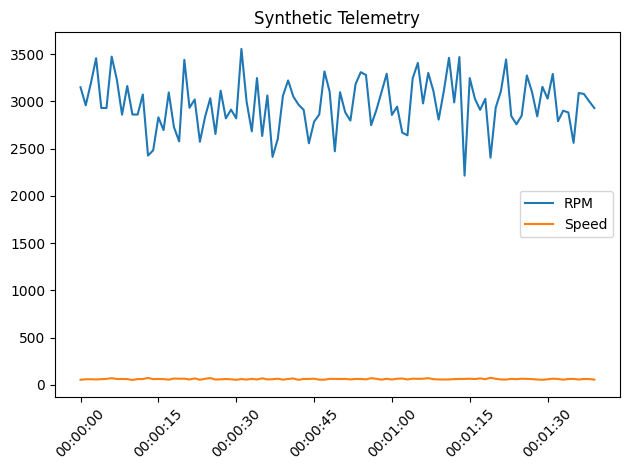

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Import Libraries
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 2. Simulate Telemetry Data
# ─────────────────────────────────────────────────────────────────────────────
np.random.seed(42)
time_steps = 100

data = {
    "timestamp": pd.date_range("2025-01-01", periods=time_steps, freq="1s"),
    "rpm": np.random.normal(3000, 300, time_steps),
    "speed": np.random.normal(60, 5, time_steps),
    "gear": np.random.randint(1, 6, time_steps),
    "brake": np.random.choice([0, 1], time_steps, p=[0.9, 0.1]),
    "coolant_temp": np.random.normal(190, 5, time_steps)
}

df = pd.DataFrame(data)

# ─────────────────────────────────────────────────────────────────────────────
# 3. Normalize Features
# ─────────────────────────────────────────────────────────────────────────────
features = ["rpm", "speed", "gear", "brake", "coolant_temp"]
normalized = (df[features] - df[features].mean()) / df[features].std()

# ─────────────────────────────────────────────────────────────────────────────
# 4. Positional Encoding
# ─────────────────────────────────────────────────────────────────────────────
# unpacks the shape of the DataFrame normalized into two scalar variables:
# T: Number of rows, representing the number of time steps (in this case, 100).
# D: Number of columns, representing the number of features (5 features: "rpm", "speed", 
# "gear", "brake", "coolant_temp").

T, D = normalized.shape

# Create tabular data
position_ids = torch.arange(T).unsqueeze(1)  # Shape: (T, 1)
# positional encoding in vector space. Each time step is represented by
# a D dimensional vector
position_embedding_layer = nn.Embedding(T, D)
# position_ids.squeeze() removes extra singleton dimensions from the tensor, 
# converting it from shape (T, 1) to (T,).
# These T position indices are then passed to the embedding layer, which returns 
# a tensor of shape (T, D) where each index is mapped to a D-dimensional 
# learnable embedding.
position_embeddings = position_embedding_layer(position_ids.squeeze())

# ─────────────────────────────────────────────────────────────────────────────
# 5. Convert to Tensor and Add Positional Embeddings
# ─────────────────────────────────────────────────────────────────────────────
inputs = torch.tensor(normalized.values, dtype=torch.float32)  # Shape: (T, D)
transformer_input = inputs + position_embeddings  # Shape: (T, D)

# ─────────────────────────────────────────────────────────────────────────────
# 6. Visualize a Sample
# ─────────────────────────────────────────────────────────────────────────────
print("Transformer input shape:", transformer_input.shape)
print("First few rows:\n", transformer_input[:5])

# Optional: plot RPM vs Speed to illustrate correlation
plt.plot(df["timestamp"], df["rpm"], label="RPM")
plt.plot(df["timestamp"], df["speed"], label="Speed")
plt.legend()
plt.title("Synthetic Telemetry")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 7. Transformer Encoder Model
# ─────────────────────────────────────────────────────────────────────────────
import torch.nn as nn
import torch.nn.functional as F

class SimpleTransformerEncoder(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Shape: (seq_len, 1, input_dim)
        x = self.transformer(x)
        x = x.squeeze(1)    # Back to (seq_len, input_dim)
        return self.output_layer(x)

# Instantiate model
model = SimpleTransformerEncoder(
    input_dim=transformer_input.shape[1], nhead=2, num_layers=2, dim_feedforward=128
)

# ─────────────────────────────────────────────────────────────────────────────
# 8. Forward Pass and Anomaly Score Calculation
# ─────────────────────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    reconstructed = model(transformer_input)

# Anomaly score: Mean Squared Error per time step
loss_per_timestep = F.mse_loss(reconstructed, transformer_input, reduction='none').mean(dim=1)
anomaly_scores = loss_per_timestep.detach().numpy()

# Attach to original dataframe
df["anomaly_score"] = anomaly_scores

# ─────────────────────────────────────────────────────────────────────────────
# 9. Visualize Results
# ─────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df["timestamp"], df["anomaly_score"], label="Anomaly Score")
plt.title("Telemetry Transformer Anomaly Detection")
plt.xlabel("Time")
plt.ylabel("Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()
